# Lab assignment №2: Gradient boosting and feature importance estimation

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

Here we will work with widely known Human Actividy Recognition (HAR) dataset. Data is available at [UCI repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones). Download it and place in `data/` folder in the same directory as this notebook. There are available both raw and preprocessed datasets. This time we will use the preprocessed one.

There are several great frameworks (listed below). However, we recommend to stick to `LightGBM` for this task.
* LightGBM by Microsoft. [Link to github](https://github.com/Microsoft/LightGBM). It is one of the most popular frameworks these days that shows both great quality and performance.
* xgboost by dlmc. [Link to github](https://github.com/dmlc/xgboost). The most famous framework which got very popular on kaggle.
* Catboost by Yandex. [Link to github](https://github.com/catboost/catboost). Novel framework by Yandex company tuned to deal well with categorical features.

Some simple preprocessing is done for you. 

Parts 1 and 3 have the same weight equal to $1$. Part 2 has weight $0.5$.

### Part 1:
Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset:

* $\geq 90\%$ accuracy: 0.5 points for this part
* $\geq 92\%$ accuracy: 0.7 points for this part
* $\geq 94\%$ accuracy: 1 point for this part

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA

In [2]:
X_train = np.genfromtxt('data/train/X_train.txt')
y_train = np.genfromtxt('data/train/y_train.txt')

X_test = np.genfromtxt('data/test/X_test.txt')
y_test = np.genfromtxt('data/test/y_test.txt')

with open('data/activity_labels.txt', 'r') as iofile:
    activity_labels = iofile.readlines()

activity_labels = [x.replace('\n', '').split(' ') for x in activity_labels]
activity_labels = dict([(int(x[0]), x[1]) for x in activity_labels])

In [3]:
activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [4]:
print(X_train.shape)
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean)/data_std
X_test = (X_test - data_mean)/data_std

(7352, 561)


The dataset has some duplicating features. File `unique_columns.txt` stores the indices of the unique ones. 

In [5]:
try: 
    unique_columns = np.genfromtxt('unique_columns.txt', delimiter=',').astype(int)
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/basic_s20/homeworks_basic/Lab2_boosting/unique_columns.txt -nc
    unique_columns = np.genfromtxt('unique_columns.txt', delimiter=',').astype(int)

X_train_unique = X_train[:, unique_columns]
X_test_unique = X_test[:, unique_columns]

PCA could be useful in this case. E.g.

In [6]:
pca = PCA(0.99)

In [7]:
X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

In [8]:
X_train_pca.shape

(7352, 179)

In [9]:
X_test_pca.shape

(2947, 179)

Text(0,0.5,'Principal component 2')

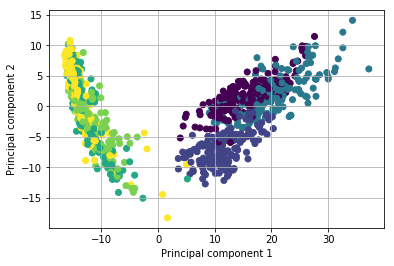

In [10]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

Text(0,0.5,'Principal component 5')

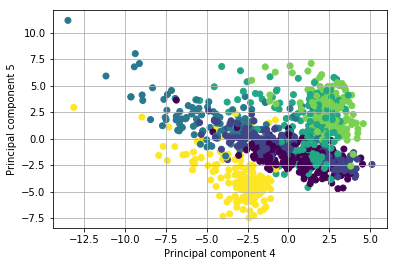

In [11]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 4')
plt.ylabel('Principal component 5')

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to use grid/random search (or any other approach) to approximate them by yourself.

Please try at least several models of different structure.

Provide the following to describe your path:

* Plot describing the model accuracy/precision/recall w.r.t. model complexity.
* ROC-AUC plot for the 3 best models you aquired (for multiclass case you might refer to the `scikit-plot` library.
* Small report describing your experiments.

[DART](https://arxiv.org/abs/1505.01866) might be useful as well in your experiments. It is available in [xgboost](https://xgboost.readthedocs.io/en/latest/tutorials/dart.html) and [LightGBM](https://lightgbm.readthedocs.io/en/latest/Parameters.html), but seems [missing in CatBoost](https://github.com/catboost/catboost/issues/1006).

__Without the report and plots maximum score for this part of the lab is 0.3 of its full weight.__

In [49]:
import sklearn
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import lightgbm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [13]:
#масштабируем данные в диапазон (0,1), посколькую они уже отнормированы по отклонению
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_unique)
X_test_scaled = scaler.transform(X_test_unique)

#обучим модель, меняя кол-во деревьев
scores = []
for n_estimators in tqdm([10,50,100,200,300]):
    clf = lightgbm.LGBMClassifier(n_estimators=n_estimators, learning_rate=0.5, random_state=42)
    clf.fit(X_train_scaled, y_train)
    #качество на тестовой выборке
    y_pred = clf.predict(X_test_scaled)
    scores.append(accuracy_score(y_test, y_pred))

100%|██████████| 5/5 [00:54<00:00, 10.87s/it]


Text(0.5,0,'Number of boosted trees')

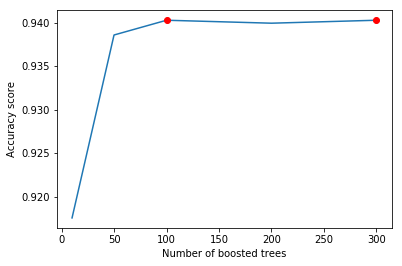

In [14]:
n_estimators = np.array([10,50,100,200,300])
scores = np.array(scores)
good_score = np.where(scores > 0.94)[0]
plt.plot(n_estimators, scores, n_estimators[good_score], scores[good_score],'ro')
plt.ylabel('Accuracy score')
plt.xlabel('Number of boosted trees')

In [15]:
#обучим модель, меняя глубину дерева
scores_depth = []
for max_depth in tqdm([1,2,3,4,5,6]):
    clf = lightgbm.LGBMClassifier(n_estimators=100, max_depth=max_depth, learning_rate=0.5, random_state=42)
    clf.fit(X_train_scaled, y_train)
    #качество на тестовой выборке
    y_pred = clf.predict(X_test_scaled)
    scores_depth.append(accuracy_score(y_test, y_pred))

100%|██████████| 6/6 [00:35<00:00,  6.00s/it]


Text(0.5,0,'Maximum tree depth')

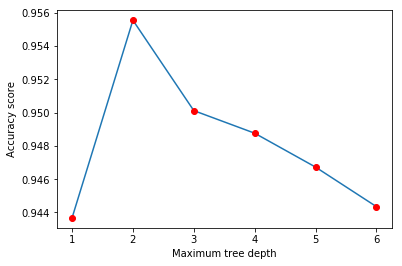

In [39]:
max_depth = np.array([1,2,3,4,5,6])
scores_depth = np.array(scores_depth)
good_score = np.where(scores_depth > 0.94)[0]
plt.plot(max_depth, scores_depth, max_depth[good_score], scores_depth[good_score],'ro')
plt.ylabel('Accuracy score')
plt.xlabel('Maximum tree depth')

Используем MinMaxScaler для предобработки данных и подбором параметров модели удалось добиться хорошей точности классификации. Но даже без подборки параметров модель уже выдавала точность больше 0.94. 

Оптимальные параметры: n_estimators(Количество деревьев бустинга)=100, max_depth(Максимальная глубина дерева для базы)= 2

__Достигнутая точность = 0.956__. 

In [40]:
clf_best = lightgbm.LGBMClassifier(n_estimators=100, max_depth=2, learning_rate=0.5, random_state=42)
clf_best.fit(X_train_scaled, y_train)
#качество на тестовой выборке
y_pred_best = clf_best.predict(X_test_scaled)
print('Gradient Boosting Decision Tree\nAccuracy:  {:.4f}'.format(accuracy_score(y_test, y_pred_best)))

Gradient Boosting Decision Tree
Accuracy:  0.9555


In [41]:
clf_dart = lightgbm.LGBMClassifier(boosting_type='dart',n_estimators=50, learning_rate=0.5)
clf_dart.fit(X_train_scaled, y_train)
#качество на тестовой выборке
y_pred_dart = clf_dart.predict(X_test_scaled)
print('DART\nAccuracy:  {:.4f}'.format(accuracy_score(y_test, y_pred_dart)))

DART
Accuracy:  0.9348


In [42]:
clf_goss = lightgbm.LGBMClassifier(boosting_type='goss',n_estimators=50, learning_rate=0.5)
clf_goss.fit(X_train_scaled, y_train)
#качество на тестовой выборке
y_pred_goss = clf_goss.predict(X_test_scaled)
print('Gradient-based One-Side Sampling\nAccuracy:  {:.4f}'.format(accuracy_score(y_test, y_pred_goss)))

Gradient-based One-Side Sampling
Accuracy:  0.9399


In [43]:
#для примера обучим лучшую модель на стандартных данных бех применения MaxMinScaler
scaler = StandardScaler()
X_train_standard = scaler.fit_transform(X_train_unique)
X_test_standard = scaler.transform(X_test_unique)
clf_standard_date = lightgbm.LGBMClassifier(n_estimators=100, max_depth=2, learning_rate=0.5, random_state=42)
clf_standard_date.fit(X_train_standard, y_train)
#качество на тестовой выборке
y_pred_standard_date = clf_standard_date.predict(X_test_standard)
print('Gradient Boosting Decision Tree Standart Date\nAccuracy:  {:.4f}'.format(accuracy_score(y_test, y_pred_standard_date)))

Gradient Boosting Decision Tree Standart Date
Accuracy:  0.9498


Оставим три модели clf_goss, clf_dart, clf_best

In [44]:
roc_auc = []
for clf in [clf_best, clf_goss, clf_dart]:
    y_prob = clf.predict_proba(X_test_scaled)
    roc_auc.append(roc_auc_score(y_test, y_prob, multi_class="ovo",average="macro"))

In [50]:
def plot_roc_curve(clf_name, y_test, y_score, n_classes=6):

    # For each class
    fpr = dict()
    tpr = dict()
    roc_auc = roc_auc_score(y_test, y_score, multi_class="ovo",average="macro")
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i],
                                      y_score[:, i])
        plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i+1))

    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.legend(loc="best")
    plt.title("ROC curve for clf = {}, ROC AUC score (macro) = {:.4f}".format(clf_name, roc_auc))
    plt.show()

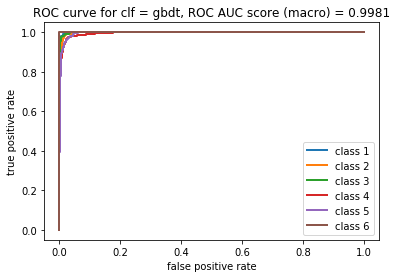

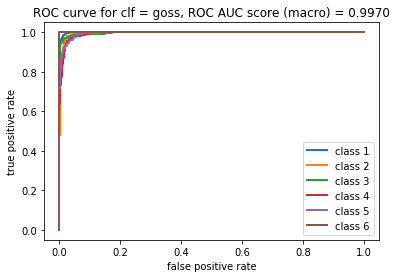

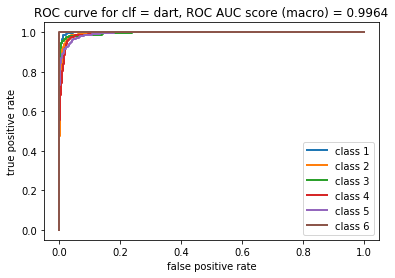

In [51]:
n_classes = 6
y_test_mult = np.zeros([y_test.size, n_classes])
for i, j in enumerate(y_test):
    y_test_mult[i,int(j) - 1] = 1

for clf in [clf_best, clf_goss, clf_dart]:
    clf_name = str(clf).split(",")[0].split('=')[1].replace("'", '')
    y_prob = clf.predict_proba(X_test_scaled)
    plot_roc_curve(clf_name, y_test_mult, y_prob)

ROC кривые для классификаторов дают какие-то слишком хорошие результаты. На раздельных графиках видим, что класс 6 почти всегда определяется со 100% успехом и при визуализации данных было видно, что один из классов более ярко выражен. Лучший результат все же получается при помощи модели с бустингом - Gradient Boosting Decision Tree, как и предполагать по оценке качества меткой accuracy. 

### Part 2. Blending the models

Take three (or more) best models and try to build the blending ensemble of them. Compare the quality of the final model using the same quality measures as above.

In [82]:
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
import cvxpy as cp

In [95]:
class BlendingClfModels(BaseEstimator):
    def __init__(self, clf_models, num_models=3, hsplit = 0.2):
        self.clf_models = clf_models
        self.hsplit = hsplit
        self.num_models = num_models

    def fit(self, X, y=None):
        preds = np.zeros((y_test.size, self.num_models))
        for i, clf in enumerate(self.clf_models):
            clf.fit(X_train, y_train)
            preds[:, i] = clf.predict(X_test).reshape(-1)
            
        return self
    
    def predict(self, X):
        meta_features = np.column_stack([
            model.predict(X) for model in self.clf_models
        ])
        return np.mean(meta_features, axis=1)
    
    def predict_proba(self, X):
        meta_features = np.column_stack([
            model.predict_proba(X) for model in self.clf_models
        ])
        return meta_features

In [97]:
models = [
    Pipeline([("MinMax", MinMaxScaler()),("lgbm", lightgbm.LGBMClassifier(n_estimators=100, max_depth=2, learning_rate=0.5, random_state=42))]),
    Pipeline([("Standard", StandardScaler()),("lgbm", lightgbm.LGBMClassifier(n_estimators=100, max_depth=2, learning_rate=0.5, random_state=42))]),
    Pipeline([("MinMax", MinMaxScaler()),("lgbm", lightgbm.LGBMClassifier(boosting_type='goss',n_estimators=50, learning_rate=0.5))]),
    ]
blending = BlendingClfModels(models)
blending.fit(X_train, y_train)

BlendingClfModels(clf_models=[Pipeline(memory=None,
                                       steps=[('MinMax',
                                               MinMaxScaler(copy=True,
                                                            feature_range=(0,
                                                                           1))),
                                              ('lgbm',
                                               LGBMClassifier(boosting_type='gbdt',
                                                              class_weight=None,
                                                              colsample_bytree=1.0,
                                                              importance_type='split',
                                                              learning_rate=0.5,
                                                              max_depth=2,
                                                              min_child_samples=20,
                              

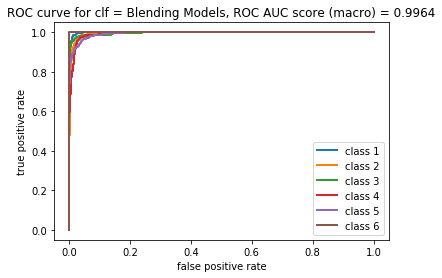

In [98]:
y_prod = blending.predict_proba(X_test)
plot_roc_curve('Blending Models', y_test_mult, y_prob)

In [104]:
y_pred = list(map(int,blending.predict(X_test)))
accuracy_score(y_test, y_pred)

0.9487614523243977

Полученный результат схож с тем, что мы получили ранее, соответственно ансамбль моделей не сильнр улучшает результат. Слегла ухудшилось Accuracy от лучшей модели, скорее всего потому что бралось среднее по предсказанным меткам.

### Part 3. Explaining the model and estimating the feature importances.

Now your goal to take three best models and estimate feature importances using this models.

* First, use the methods that libraries provide by default (e.g. `lightgbm.plot_importance`).
* Next, use the [`shap`](https://github.com/slundberg/shap) library to explain the models behaviour and analyse the model performance. Compare the feature importances estimated by `shap` and by methods on the previous step.

In [ ]:
# Your code here.